In [15]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, layers, activation='relu', learning_rate=0.01, dropout_rate=0.2, momentum=0.9):
        """
        Initialize the neural network.
        :param layers: List of layer sizes, e.g., [input_size, hidden_size, output_size]
        :param activation: Activation function for hidden layers ('relu', 'tanh', 'sigmoid')
        :param learning_rate: Learning rate for gradient descent
        :param dropout_rate: Dropout rate for regularization
        :param momentum: Momentum for gradient descent
        """
        self.layers = layers
        self.activation = activation
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.momentum = momentum
        self.weights = []
        self.biases = []
        self.velocity = []
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.initialize_weights()

    def initialize_weights(self):
        """Initialize weights and biases randomly."""
        for i in range(1, len(self.layers)):
            self.weights.append(np.random.randn(self.layers[i-1], self.layers[i]) * 0.01)
            self.biases.append(np.zeros((1, self.layers[i])))
            self.velocity.append(np.zeros_like(self.weights[-1]))  # Initialize velocity for momentum

    def activation_function(self, x, derivative=False):
        """Activation functions and their derivatives."""
        if self.activation == 'relu':
            if derivative:
                return (x > 0).astype(float)
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            if derivative:
                return 1 - np.tanh(x) ** 2
            return np.tanh(x)
        elif self.activation == 'sigmoid':
            if derivative:
                return x * (1 - x)
            return 1 / (1 + np.exp(-x))

    def forward_propagation(self, X, training=True):
        """Forward pass through the network."""
        self.layer_outputs = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activation_function(z)
            if training and i < len(self.weights) - 1:  # Apply dropout to hidden layers
                dropout_mask = (np.random.rand(*a.shape) > self.dropout_rate) / (1 - self.dropout_rate)
                a *= dropout_mask
            self.layer_outputs.append(a)
        return self.layer_outputs[-1]

    def backward_propagation(self, X, y):
        """Backward pass to compute gradients."""
        m = X.shape[0]  # Number of samples in the batch
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]

        # Output layer error
        error = self.layer_outputs[-1] - y.reshape(-1, 1)  # Ensure y has shape (batch_size, 1)
        dW[-1] = np.dot(self.layer_outputs[-2].T, error) / m
        db[-1] = np.sum(error, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            error = np.dot(error, self.weights[i+1].T) * self.activation_function(self.layer_outputs[i+1], derivative=True)
            dW[i] = np.dot(self.layer_outputs[i].T, error) / m
            db[i] = np.sum(error, axis=0, keepdims=True) / m

    # Update weights with momentum
        for i in range(len(self.weights)):
            self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * dW[i]
            self.weights[i] += self.velocity[i]
            self.biases[i] -= self.learning_rate * db[i]

    def compute_loss(self, y_true, y_pred):
        """Compute binary cross-entropy loss."""
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def compute_accuracy(self, y_true, y_pred):
        """Compute accuracy."""
        return np.mean((y_pred > 0.5) == y_true)

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Train the model."""
        for epoch in range(epochs):
            # Mini-batch training
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, y_batch)

            # Compute training and validation loss/accuracy
            train_pred = self.forward_propagation(X_train, training=False)
            val_pred = self.forward_propagation(X_val, training=False)
            self.train_loss.append(self.compute_loss(y_train, train_pred))
            self.val_loss.append(self.compute_loss(y_val, val_pred))
            self.train_accuracy.append(self.compute_accuracy(y_train, train_pred))
            self.val_accuracy.append(self.compute_accuracy(y_val, val_pred))

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {self.train_loss[-1]:.4f}, Val Loss: {self.val_loss[-1]:.4f}, "
                  f"Train Acc: {self.train_accuracy[-1]:.4f}, Val Acc: {self.val_accuracy[-1]:.4f}")

    def plot_loss_curve(self):
        """Plot training and validation loss."""
        plt.plot(self.train_loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_accuracy_curve(self):
        """Plot training and validation accuracy."""
        plt.plot(self.train_accuracy, label='Training Accuracy')
        plt.plot(self.val_accuracy, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [16]:
# Ensure y_train and y_val are column vectors
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

Epoch 1/20, Train Loss: 1.0385, Val Loss: 1.0630, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 2/20, Train Loss: 0.8396, Val Loss: 0.8554, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 3/20, Train Loss: 0.7620, Val Loss: 0.7732, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 4/20, Train Loss: 0.7264, Val Loss: 0.7345, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 5/20, Train Loss: 0.7090, Val Loss: 0.7151, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 6/20, Train Loss: 0.7004, Val Loss: 0.7050, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 7/20, Train Loss: 0.6961, Val Loss: 0.6996, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 8/20, Train Loss: 0.6940, Val Loss: 0.6968, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 9/20, Train Loss: 0.6929, Val Loss: 0.6952, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 10/20, Train Loss: 0.6924, Val Loss: 0.6944, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 11/20, Train Loss: 0.6922, Val Loss: 0.6939, Train Acc: 0.5230, Val Acc: 0.5100
Epoch 12/20, Train Loss: 0.6921, Val Loss: 0.6936, Train Acc: 0

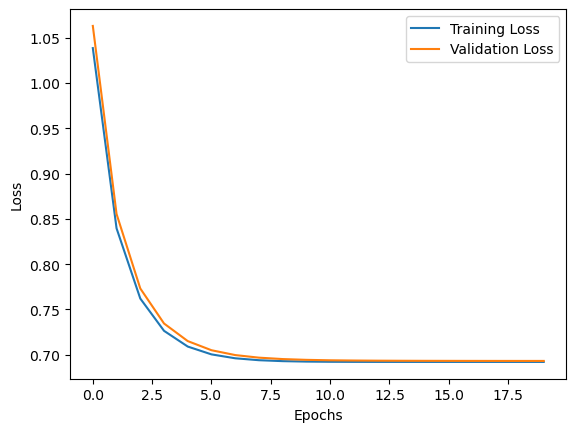

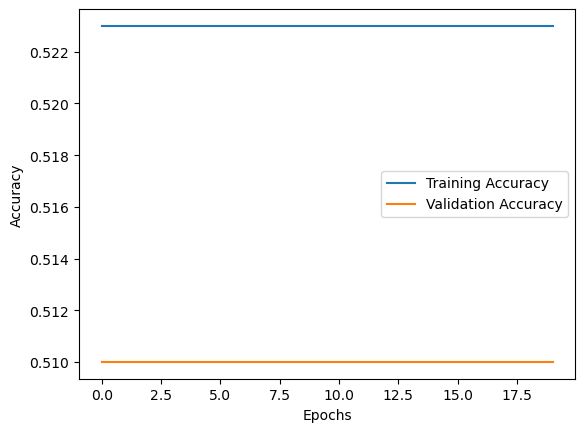

In [17]:
# Example dataset (replace with your actual dataset)
X_train = np.random.rand(1000, 64)  # 1000 samples, 64 features
y_train = np.random.randint(0, 2, 1000).reshape(-1, 1)  # Binary labels (0 or 1)
X_val = np.random.rand(200, 64)  # 200 validation samples
y_val = np.random.randint(0, 2, 200).reshape(-1, 1)

# Define the neural network architecture
layers = [X_train.shape[1], 64, 32, 1]  # Input layer, two hidden layers, output layer
model = NeuralNetwork(layers=layers, activation='relu', learning_rate=0.01, dropout_rate=0.2, momentum=0.9)

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)

# Plot training and validation loss
model.plot_loss_curve()

# Plot training and validation accuracy
model.plot_accuracy_curve()